In [1]:
from casadi import Function
from casadi import SX
from casadi import MX
from casadi import vertcat
from casadi import nlpsol
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
k_1 = 10.0
n_t = 1000.0
# n_t = 500.0
qdot_t = 3.0

In [3]:
x_A = SX.sym("x_A")
x_B = SX.sym("x_B")
x_C = SX.sym("x_C")

In [4]:
qdot_A = SX.sym("qdot_A")
qdot_B = qdot_t - qdot_A

In [5]:
x = vertcat(x_A, x_B, x_C)
p = vertcat(qdot_A)

In [6]:
ndot_gen_A = -k_1 * x_A
ndot_gen_B = +0.0
ndot_gen_C = -ndot_gen_A

In [7]:
xdot_A = (qdot_A - qdot_t * x_A + ndot_gen_A) / n_t
xdot_B = (qdot_B - qdot_t * x_B + ndot_gen_B) / n_t
xdot_C = (0.0    - qdot_t * x_C + ndot_gen_C) / n_t

In [8]:
F_xdot_A = Function("F_xdot_A", [x, p], [xdot_A])
F_xdot_B = Function("F_xdot_B", [x, p], [xdot_B])
F_xdot_C = Function("F_xdot_C", [x, p], [xdot_C])

In [9]:
F_xdot_A

Function(F_xdot_A:(i0[3],i1)->(o0) SXFunction)

In [10]:
F_xdot_A([0.5, 0.5, 0], 10),\
F_xdot_B([0.5, 0.5, 0], 10),\
F_xdot_C([0.5, 0.5, 0], 10)

(DM(0.0035), DM(-0.0085), DM(0.005))

In [11]:
Np = 100
tau = 15.0

Q = 1.0
R = 0.05
S = 100.0

x_A_max = 0.9

In [12]:
x0_A = SX.sym("x0_A")
x0_B = SX.sym("x0_B")
x0_C = SX.sym("x0_C")
x0 = vertcat(x0_A, x0_B, x0_C)

qdot0_A = x_A_max*qdot_t
qdot0_A = 0.4*qdot_t

In [13]:
xs_C = SX.sym("xs_C", Np+1)

In [14]:
J = 0.0
g = []

lbx = [0.0]
ubx = [x_A_max*qdot_t]

v_qdot_A = [SX.sym(f"v_dot_A_0")]

xt_A = x0_A
xt_B = x0_B
xt_C = x0_C

for ts in range(1, Np+1):
    v_qdot_A_ts = SX.sym(f"v_dot_A_{ts}")
    v_qdot_A.append(v_qdot_A_ts)
    
    lbx.extend([0.0])
    ubx.extend([x_A_max*qdot_t])

    xn = vertcat(xt_A, xt_B, xt_C)
    pn = v_qdot_A_ts
        
    xt_A = xt_A + tau * F_xdot_A(xn, pn)
    xt_B = xt_B + tau * F_xdot_B(xn, pn)
    xt_C = xt_C + tau * F_xdot_C(xn, pn)
    
    J += Q * pow(xt_C - xs_C[ts], 2) +\
         R * pow(v_qdot_A_ts - v_qdot_A[ts-1], 2)
    
g.append(v_qdot_A[0] - qdot0_A)
    
J += S * pow(xt_C - xs_C[-1], 2)

In [15]:
nlp = {
    "f": J,
    "x": vertcat(*v_qdot_A), 
    "g": vertcat(*g),
    "p": vertcat(xs_C, x0)
}
solver = nlpsol("solver", "ipopt", nlp)

In [16]:
solver

Function(solver:(x0[101],p[104],lbx[101],ubx[101],lbg,ubg,lam_x0[101],lam_g0)->(x[101],f,g,lam_x[101],lam_g,lam_p[104]) IpoptInterface)

In [17]:
xs_C_num = np.zeros(Np+1)
xs_C_num[:3*Np//4] = 0.3
xs_C_num[3*Np//4:] = 0.6
x0_num = [0.0, 1.0, 0.0]

# xs_C_num = np.zeros(Np+1)
# xs_C_num[:1*Np//2] = 0.3
# xs_C_num[1*Np//2:] = 0.6
# x0_num = [0.1, 0.6, 0.3]

p = [*xs_C_num, *x0_num]

In [18]:
solution = solver(x0=np.zeros(Np+1), p=p, lbx=lbx, ubx=ubx, lbg=0.0, ubg=0.0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        1
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4954

Total number of variables............................:      101
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      101
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality co

In [19]:
steps = list(range(Np+1))
qdot_A_opt = solution["x"].full().ravel()

In [20]:
xt_A = np.zeros(Np+1)
xt_B = np.zeros(Np+1)
xt_C = np.zeros(Np+1)

xt_A[0] = x0_num[0]
xt_B[0] = x0_num[1]
xt_C[0] = x0_num[2]

for ts in range(1, Np+1):
    xn = vertcat(xt_A[ts-1], xt_B[ts-1], xt_C[ts-1])
    pn = qdot_A_opt[ts-1]
        
    xt_A[ts] = xt_A[ts-1] + tau * F_xdot_A(xn, pn)
    xt_B[ts] = xt_B[ts-1] + tau * F_xdot_B(xn, pn)
    xt_C[ts] = xt_C[ts-1] + tau * F_xdot_C(xn, pn)
    
xt_Z = xt_A + xt_B + xt_C

In [21]:
xs_C_max = np.clip(xs_C_num + 0.05, 0.0, 1.0)
xs_C_min = np.clip(xs_C_num - 0.05, 0.0, 1.0)

good = (xt_C >= xs_C_min) & (xt_C <= xs_C_max)

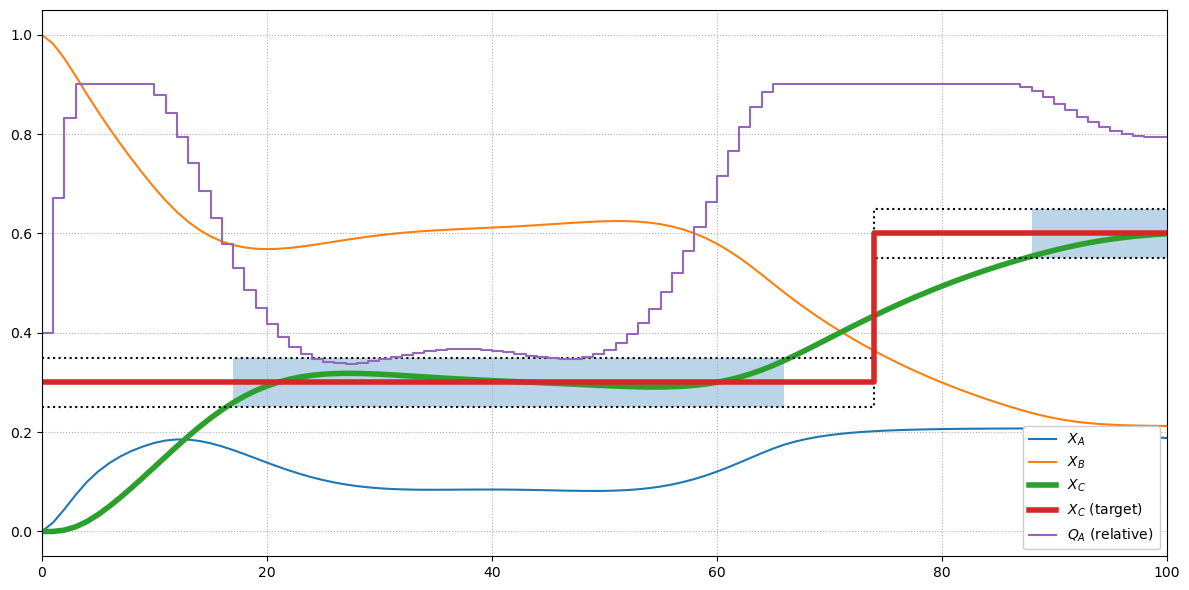

In [22]:
plt.style.use("default")
plt.figure(figsize=(12, 6))
plt.plot(steps, xt_A, label="$X_A$")
plt.plot(steps, xt_B, label="$X_B$")
plt.plot(steps, xt_C, lw=4, label="$X_C$")
plt.step(steps, xs_C_max, "k:", label="_none_")
plt.step(steps, xs_C_min, "k:", label="_none_")
plt.step(steps, xs_C_num, lw=4, label="$X_C$ (target)")
plt.step(steps, qdot_A_opt / qdot_t, label="$Q_A$ (relative)", where="post")
plt.fill_between(steps, xs_C_min, xs_C_max, where=good, alpha=0.3)
plt.grid(linestyle=":")
plt.legend(loc=4, fancybox=True,  framealpha=1.0)
plt.xlim(0, Np)
plt.tight_layout()

In [23]:
sum(good.astype("u8")) / len(good)

0.6237623762376238